# Resource usage - exploratory analysis

#### Maria Silva, April 2025

## 1. Imports and settings

Let's start by importing the necessary libraries and setting up some directories and files.


In [1]:
import os
import sys
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

In [2]:
# plotting theme
sns.set_theme(
    style="whitegrid", palette="Set2", rc={"figure.dpi": 500, "axes.titlesize": 15}
)

In [3]:
# Main directories and files
current_path = os.getcwd()
repo_dir = os.path.abspath(os.path.join(current_path, ".."))
src_dir = os.path.join(repo_dir, "src")
data_dir = os.path.join(repo_dir, "data")
op_files_dir = os.path.join(data_dir, "aggregated_opcodes_v2", "*", "file.parquet")

In [4]:
# import internal packages
sys.path.append(src_dir)
from resource_gas_split import split_opcode_gas_by_resource, split_intrinsic_base_gas_by_resource

## 2. Load data

Now, let's load the data. We will start by loading the opcodes used for blocks 22000000 to 22001999.

In [5]:
# Load parquet files with duckdb
query = f"""
SELECT block_height, tx_hash, op, op_gas_cost, op_gas_pair_count
FROM read_parquet(
    '{op_files_dir}', 
    hive_partitioning=True, 
    filename=True,
    file_row_number=True,
    union_by_name=True
    )
WHERE block_height BETWEEN 22000000 AND 22001999;
"""
raw_usage_df = duckdb.connect().execute(query).fetchdf()
# Print info
raw_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13518730 entries, 0 to 13518729
Data columns (total 5 columns):
 #   Column             Dtype  
---  ------             -----  
 0   block_height       int64  
 1   tx_hash            object 
 2   op                 object 
 3   op_gas_cost        float64
 4   op_gas_pair_count  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 515.7+ MB


In [6]:
raw_usage_df["block_height"].agg(["min", "max"])

min    22000020
max    22001999
Name: block_height, dtype: int64

Note that we only have data starting at 22000020. Now, we can load the gas used per transaction.

In [7]:
# Load parquet file
tx_gas_usage_df = pd.read_parquet(
    os.path.join(data_dir, "tx_gas_usage_22000000_22006000.parquet")
)
# Clean up columns
tx_gas_usage_df = tx_gas_usage_df.drop(columns=["block_height"])
tx_gas_usage_df.columns = [
    "tx_hash",
    "tx_gas_cost",
    "tx_gas_limit",
    "tx_input_data_gas_cost",
    "is_contract_creation",
    "is_success",
]
# Print info
tx_gas_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937679 entries, 0 to 937678
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   tx_hash                 937679 non-null  object
 1   tx_gas_cost             937679 non-null  int64 
 2   tx_gas_limit            937679 non-null  int64 
 3   tx_input_data_gas_cost  937679 non-null  int64 
 4   is_contract_creation    937679 non-null  int64 
 5   is_success              937679 non-null  object
dtypes: int64(4), object(2)
memory usage: 42.9+ MB


## 3. Process data

In [8]:
# Add total transaction gas
usage_df = raw_usage_df.merge(tx_gas_usage_df, on="tx_hash", how="left")
# Fix op_gas_cost for transactions with no opcodes
usage_df["op_gas_cost"] = np.where(
    (usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"]))
    & (usage_df["is_contract_creation"] == 0),
    usage_df["tx_gas_cost"] - usage_df["tx_input_data_gas_cost"] - 21000.0,
    usage_df["op_gas_cost"],
)
usage_df["op_gas_cost"] = np.where(
    (usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"]))
    & (usage_df["is_contract_creation"] == 1),
    usage_df["tx_gas_cost"] - usage_df["tx_input_data_gas_cost"] - 53000.0,
    usage_df["op_gas_cost"],
)
# Clean up repeated opcodes
usage_df["op"] = np.where(usage_df["op"].str.startswith("DUP"), "DUP", usage_df["op"])
usage_df["op"] = np.where(usage_df["op"].str.startswith("SWAP"), "SWAP", usage_df["op"])
usage_df["op"] = np.where(
    (usage_df["op"].str.startswith("PUSH")) & (usage_df["op"] != "PUSH0"),
    "PUSH",
    usage_df["op"],
)
# Compute total gas cost for opcode
usage_df["op_total_gas_cost"] = usage_df["op_gas_cost"] * usage_df["op_gas_pair_count"]
# Print info
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13518730 entries, 0 to 13518729
Data columns (total 11 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   block_height            int64  
 1   tx_hash                 object 
 2   op                      object 
 3   op_gas_cost             float64
 4   op_gas_pair_count       int64  
 5   tx_gas_cost             int64  
 6   tx_gas_limit            int64  
 7   tx_input_data_gas_cost  int64  
 8   is_contract_creation    int64  
 9   is_success              object 
 10  op_total_gas_cost       float64
dtypes: float64(2), int64(6), object(3)
memory usage: 1.1+ GB


In [9]:
# Aggregate costs by transaction
comp_df = (
    usage_df.groupby(["block_height", "tx_hash"])
    .agg(
        {
            "op_total_gas_cost": "sum",
            "tx_gas_cost": "first",
            "tx_input_data_gas_cost": "first",
            "is_contract_creation": "max",
        }
    )
    .reset_index()
)
# Set column names
comp_df.columns = [
    "block_height",
    "tx_hash",
    "op_gas_cost",
    "tx_gas_cost",
    "tx_input_data_cost",
    "is_contract_creation",
]
# Compute intrinsic cost
comp_df["intrinsic_base_cost"] = np.where(
    comp_df["is_contract_creation"] == 1, 53000.0, 21000.0
)
# Estimate gas refunds
comp_df["tx_gas_refund"] = (
    comp_df["op_gas_cost"]
    + comp_df["tx_input_data_cost"]
    + comp_df["intrinsic_base_cost"]
    - comp_df["tx_gas_cost"]
)
# Estimate intrinsic access cost
comp_df["intrinsic_access_cost"] = np.where(
    comp_df["tx_gas_refund"] < 0, -comp_df["tx_gas_refund"], 0.0
)
# Fix negative refunds
comp_df["tx_gas_refund"] = np.where(
    comp_df["tx_gas_refund"] < 0, 0.0, comp_df["tx_gas_refund"]
)
comp_df["tx_gas_refund_rate"] = comp_df["tx_gas_refund"] / (
    comp_df["op_gas_cost"]
    + comp_df["tx_input_data_cost"]
    + comp_df["intrinsic_base_cost"]
)
# Print head
comp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288411 entries, 0 to 288410
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   block_height           288411 non-null  int64  
 1   tx_hash                288411 non-null  object 
 2   op_gas_cost            288411 non-null  float64
 3   tx_gas_cost            288411 non-null  int64  
 4   tx_input_data_cost     288411 non-null  int64  
 5   is_contract_creation   288411 non-null  int64  
 6   intrinsic_base_cost    288411 non-null  float64
 7   tx_gas_refund          288411 non-null  float64
 8   intrinsic_access_cost  288411 non-null  float64
 9   tx_gas_refund_rate     288411 non-null  float64
dtypes: float64(5), int64(4), object(1)
memory usage: 22.0+ MB


In [10]:
ignore_txs = comp_df[comp_df["tx_gas_refund_rate"] > 0.2]["tx_hash"].unique()
len(ignore_txs)/comp_df["tx_hash"].nunique()

0.0003883347029066159

## 4. Split gas usage by resource type

In [11]:
# Apply opcode resource split rule to each row
op_gas_by_resource = (
    usage_df[~usage_df["tx_hash"].isin(ignore_txs)]
    .apply(
        lambda x: split_opcode_gas_by_resource(x["op"], x["op_gas_cost"], x["op_gas_pair_count"], x["tx_hash"]),
        axis=1,
    )
    .tolist()
)
# Aggregate by tx_hash and sum up the resources
op_gas_by_resource_df = (
    pd.DataFrame(op_gas_by_resource)
    .drop(columns=["op"])
    .groupby("tx_hash")
    .sum()
    .reset_index()
)

In [12]:
# Apply base intrinsic resource split rule to each row
intrinsic_base_by_resource = (
    comp_df[~comp_df["tx_hash"].isin(ignore_txs)]
    .apply(
        lambda x: split_intrinsic_base_gas_by_resource(
            x["intrinsic_base_cost"], x["tx_hash"]
        ),
        axis=1,
    )
    .tolist()
)
# Transform to DataFrame
intrinsic_base_by_resource_df = pd.DataFrame(intrinsic_base_by_resource)

In [13]:
# Assign input data component to "history"
input_data_by_resource_df = comp_df[~comp_df["tx_hash"].isin(ignore_txs)][
    ["tx_hash", "tx_input_data_cost"]
].copy()
input_data_by_resource_df.columns = ["tx_hash", "history_growth"]

# Assign refunds to "state" (and male negative)
refunds_by_resource_df = comp_df[~comp_df["tx_hash"].isin(ignore_txs)][
    ["tx_hash", "tx_gas_refund"]
].copy()
refunds_by_resource_df.columns = ["tx_hash", "state_growth"]
refunds_by_resource_df["state_growth"] = -refunds_by_resource_df["state_growth"]

# Assign intrinsic access component to "access"
intrinsic_access_by_resource_df = comp_df[~comp_df["tx_hash"].isin(ignore_txs)][
    ["tx_hash", "intrinsic_access_cost"]
].copy()
intrinsic_access_by_resource_df.columns = ["tx_hash", "access"]

# Ignored transactions
ignored_gas_df = comp_df[comp_df["tx_hash"].isin(ignore_txs)][
    ["tx_hash", "tx_gas_cost"]
].copy()
ignored_gas_df.columns = ["tx_hash", "unassigned"]

In [14]:
# Join dataframes
gas_by_resource_df = pd.concat(
    [
        op_gas_by_resource_df,
        intrinsic_base_by_resource_df,
        input_data_by_resource_df,
        refunds_by_resource_df,
        intrinsic_access_by_resource_df,
        ignored_gas_df,
    ],
    ignore_index=True,
)
# Aggreate and update columns
gas_by_resource_df = gas_by_resource_df.groupby("tx_hash").sum().reset_index()
gas_by_resource_df.columns = [
    "tx_hash",
    "Compute",
    "Access",
    "Memory",
    "History",
    "Bloom topics",
    "State",
    "Unassigned",
]
# Add block height
gas_by_resource_df = gas_by_resource_df.merge(
    comp_df[["block_height", "tx_hash"]], on="tx_hash", how="left"
)
# Add state without Refunds
exc_refund_df = pd.concat(
    [
        op_gas_by_resource_df,
        input_data_by_resource_df,
        intrinsic_base_by_resource_df,
        intrinsic_access_by_resource_df,
    ],
    ignore_index=True,
).groupby("tx_hash")["state_growth"].sum().reset_index()
exc_refund_df.columns = ["tx_hash", "State (exc. Refunds)"]
gas_by_resource_df = gas_by_resource_df.merge(
    exc_refund_df, on="tx_hash", how="left"
)
# print info
gas_by_resource_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288411 entries, 0 to 288410
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   tx_hash               288411 non-null  object 
 1   Compute               288411 non-null  float64
 2   Access                288411 non-null  float64
 3   Memory                288411 non-null  float64
 4   History               288411 non-null  float64
 5   Bloom topics          288411 non-null  float64
 6   State                 288411 non-null  float64
 7   Unassigned            288411 non-null  float64
 8   block_height          288411 non-null  int64  
 9   State (exc. Refunds)  288299 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 22.0+ MB


In [15]:
# Melt (for plotting)
melt_gas_by_resource_df = gas_by_resource_df.melt(
    id_vars=["block_height", "tx_hash"], var_name="Resource", value_name="gas_cost"
).sort_values("Resource")

## 5. Analyze gas by resource

In [16]:
# Transactions with unassigned gas
print(sum(gas_by_resource_df["Unassigned"]>0)/len(gas_by_resource_df))
print(gas_by_resource_df["Unassigned"].sum()/ 1_000_000)

0.0033251158936378985
3153.453312


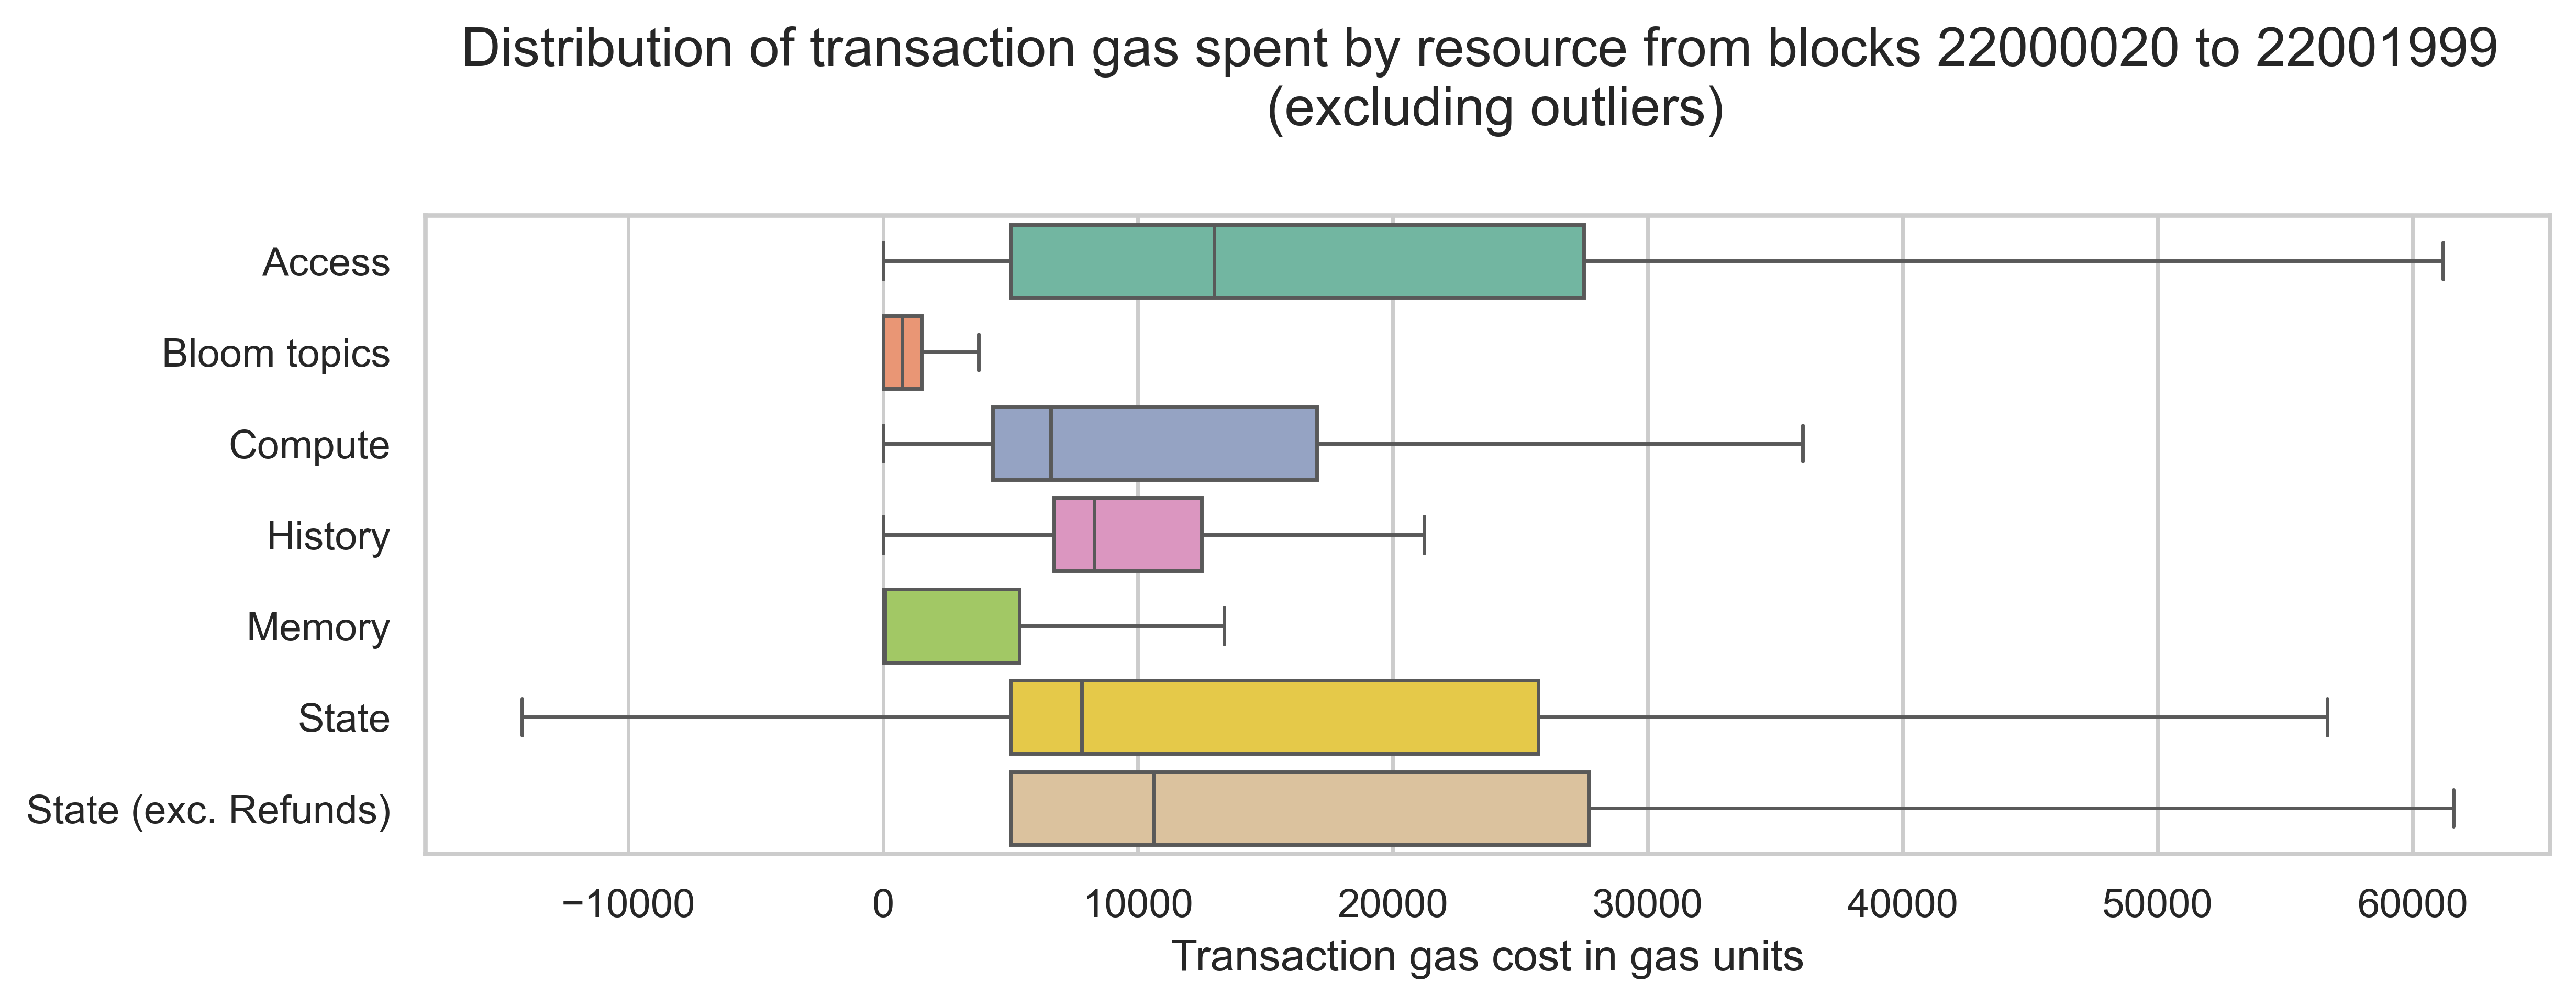

In [17]:
plt.figure(figsize=(10, 4))
sns.boxplot(
    y="Resource",
    x="gas_cost",
    data=melt_gas_by_resource_df[melt_gas_by_resource_df["Resource"]!="Unassigned"],
    hue="Resource",
    legend=False,
    showfliers=False,
)
plt.title(
    "Distribution of transaction gas spent by resource from blocks 22000020 to 22001999 \n (excluding outliers)",
    pad=25,
)
plt.ylabel("")
plt.xlabel("Transaction gas cost in gas units")
plt.tight_layout()
plt.show()

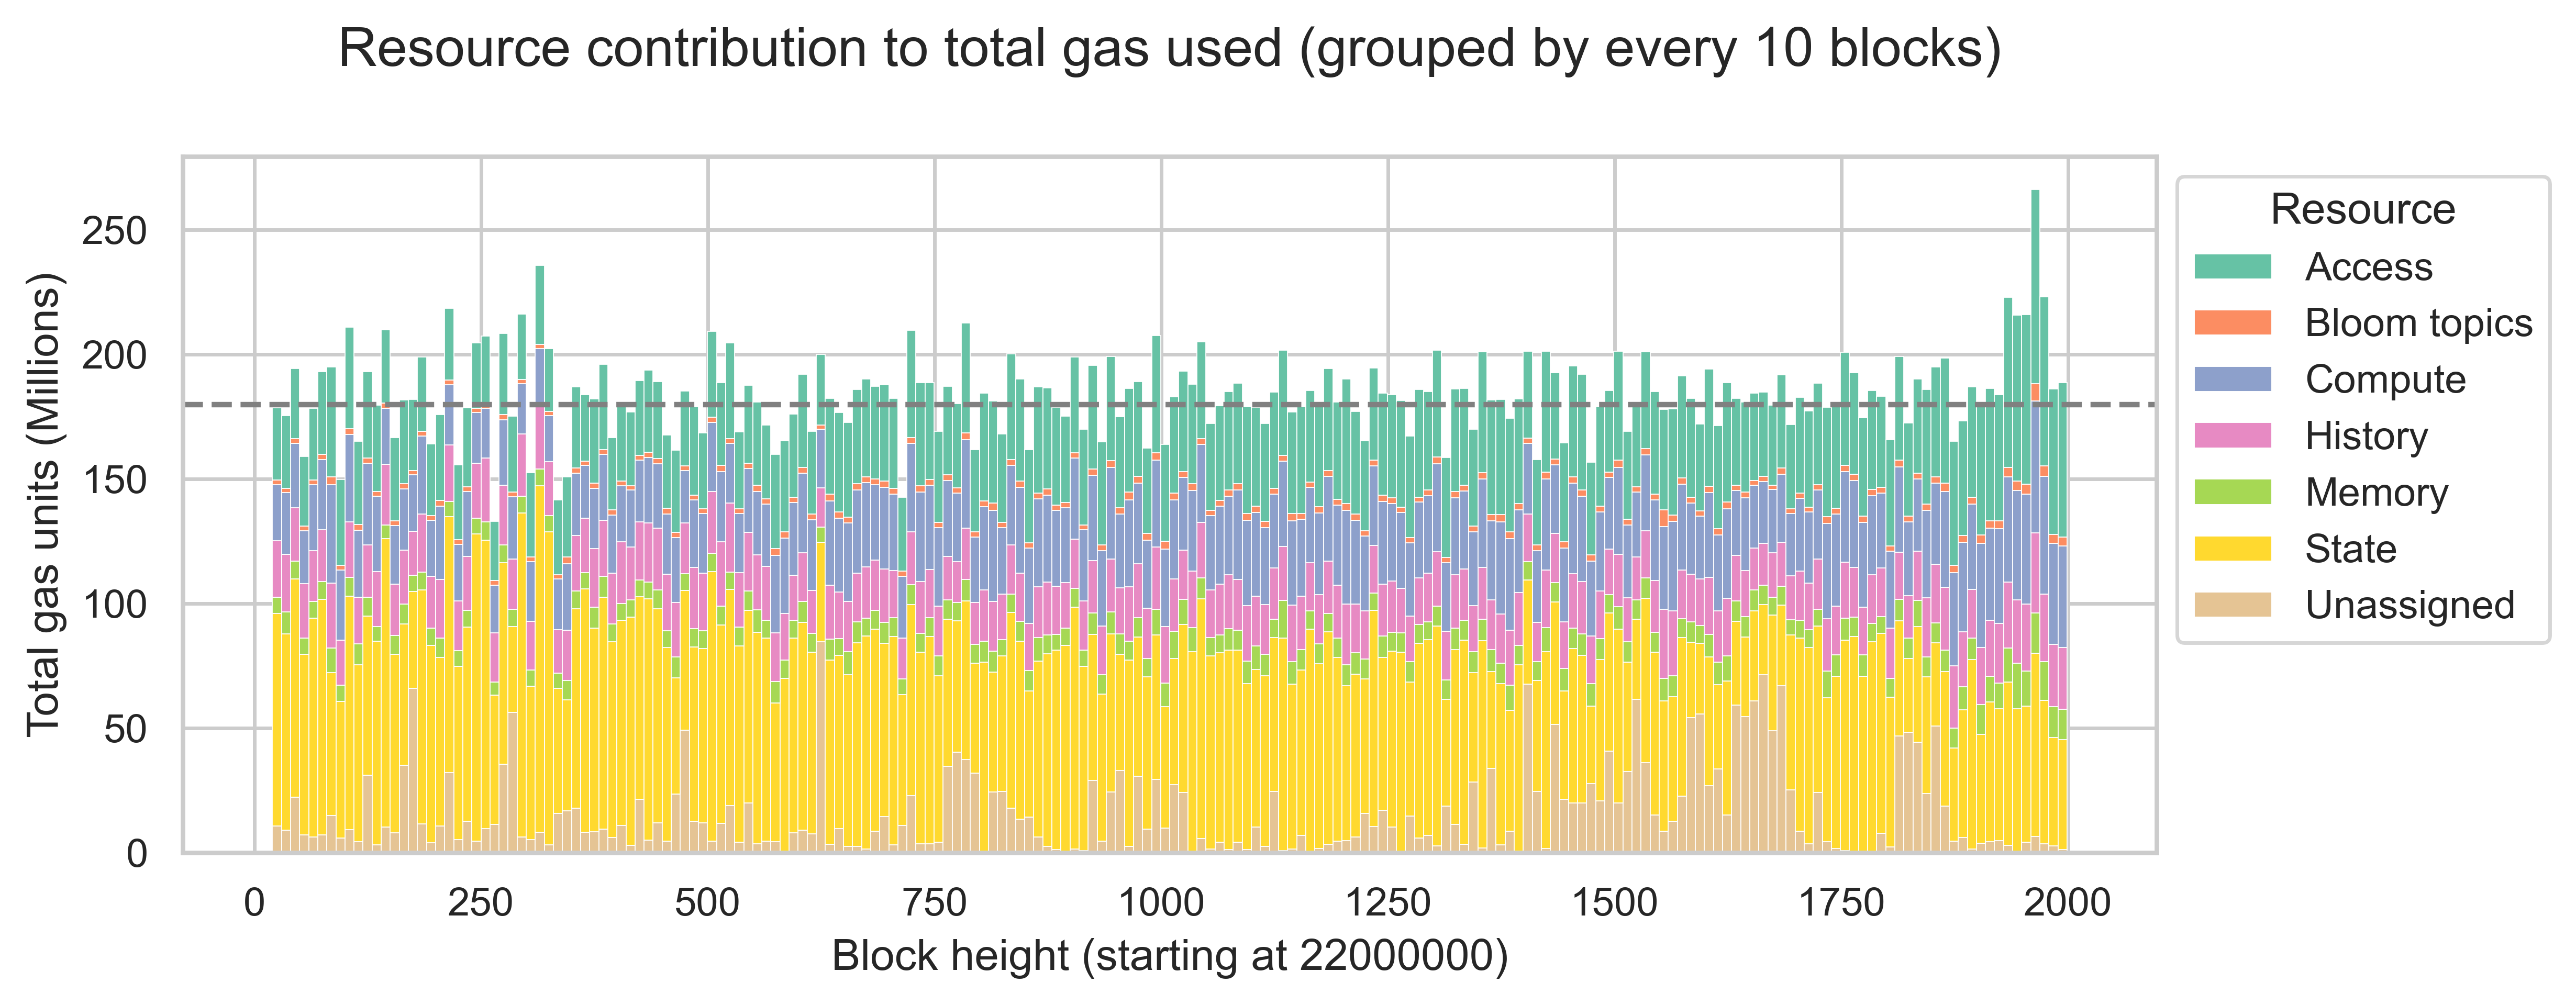

In [18]:
temp_df = (
    melt_gas_by_resource_df[
        melt_gas_by_resource_df["Resource"] != "State (exc. Refunds)"
    ]
    .groupby(["block_height", "Resource"])["gas_cost"]
    .sum()
    / 1_000_000
)
temp_df = temp_df.reset_index().sort_values("Resource")
temp_df["block_height"] = temp_df["block_height"] - 22000000

plt.figure(figsize=(10, 4))
ax = sns.histplot(
    temp_df,
    x="block_height",
    weights="gas_cost",
    hue="Resource",
    multiple="stack",
    binwidth=10,
    alpha=1.0
)
plt.title(
    "Resource contribution to total gas used (grouped by every 10 blocks)",
    pad=25,
)
plt.xlabel("Block height (starting at 22000000)")
plt.ylabel("Total gas units (Millions)")
plt.axhline(y=180, color='grey', linestyle='--', label='target block size')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [19]:
temp_df = (
    melt_gas_by_resource_df[
        melt_gas_by_resource_df["Resource"] != "State (exc. Refunds)"
    ]
    .groupby(["Resource"])["gas_cost"]
    .sum()
    / 1_000_000
)
print(temp_df.sort_values(ascending=False))
print(temp_df.sort_values(ascending=False)/temp_df.sum())

Resource
State           13383.256989
Access           7645.354423
Compute          6024.355998
History          4155.877801
Unassigned       3153.453312
Memory           1612.737060
Bloom topics      472.868250
Name: gas_cost, dtype: float64
Resource
State           0.367189
Access          0.209761
Compute         0.165287
History         0.114022
Unassigned      0.086519
Memory          0.044248
Bloom topics    0.012974
Name: gas_cost, dtype: float64


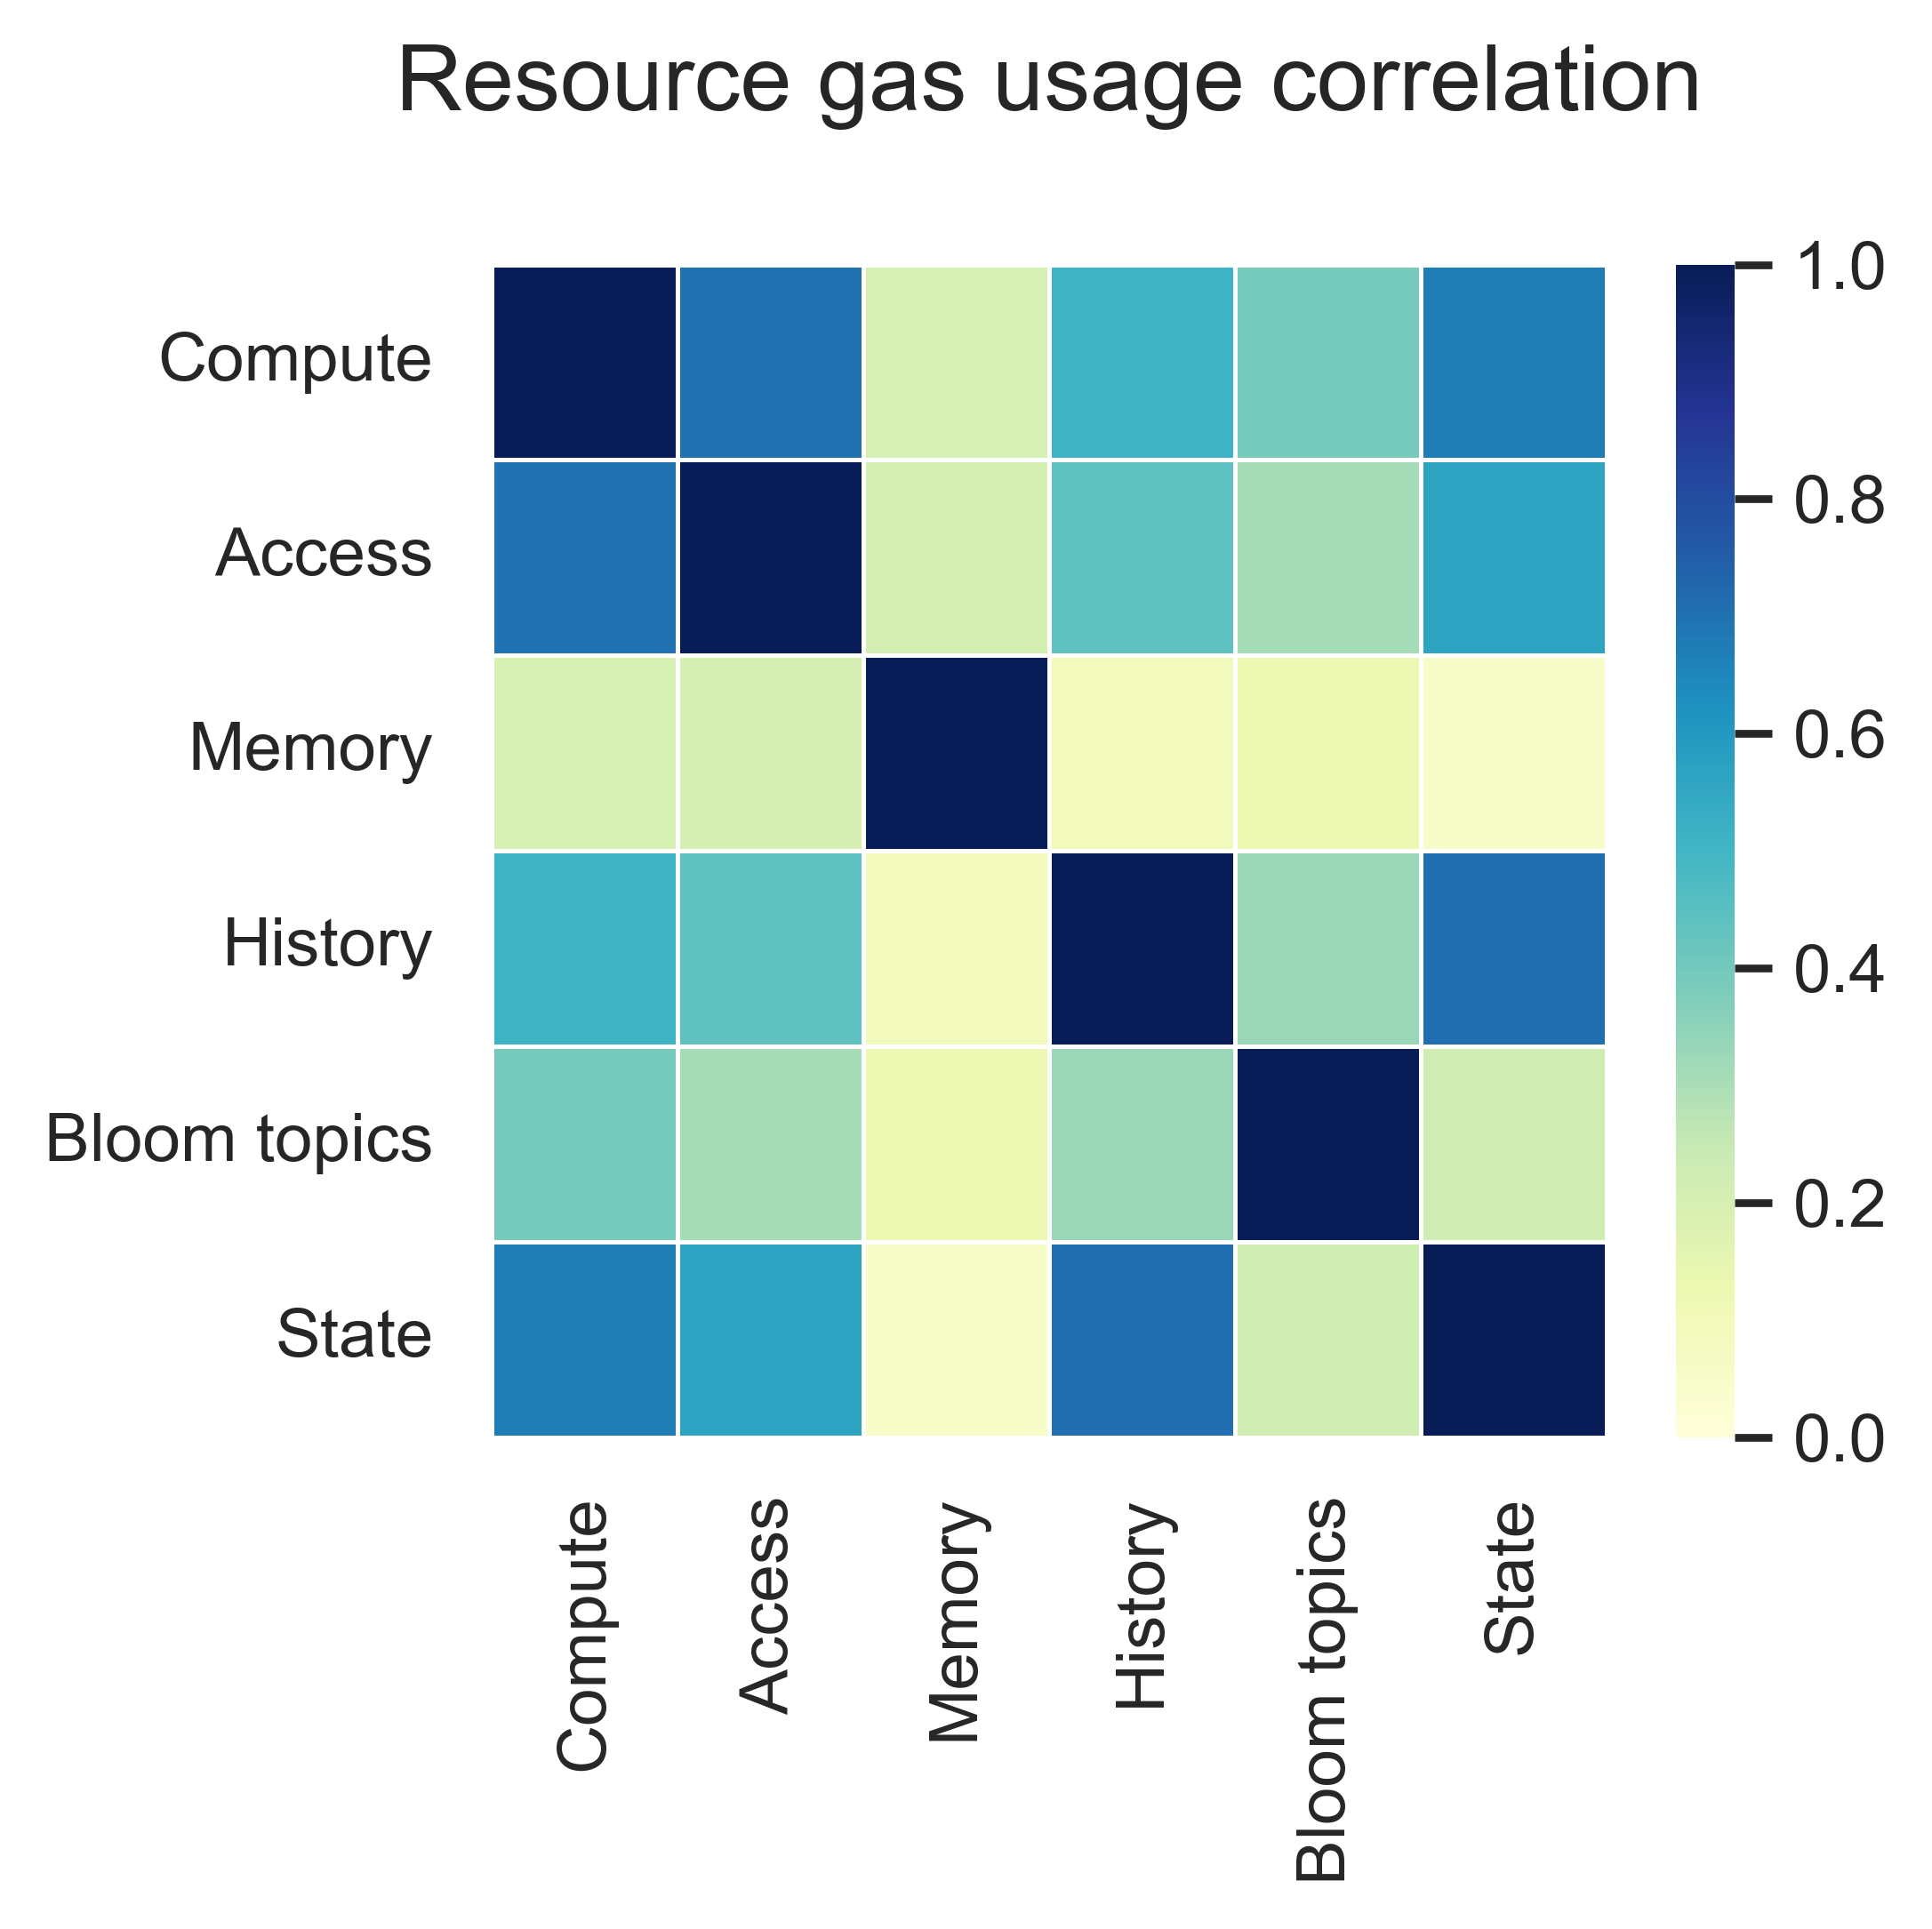

In [20]:
temp_df = gas_by_resource_df.drop(
    columns=["block_height", "Unassigned", "State (exc. Refunds)"]
).set_index("tx_hash")
corr_mat = temp_df.corr()
plt.figure(figsize=(4.5, 4.5))
ax = sns.heatmap(corr_mat, cmap="YlGnBu", linewidths=0.5, vmin=0, vmax=1)
plt.title("Resource gas usage correlation", pad=25)
plt.tight_layout()
plt.show()

## 6. Analyze block utilization

In [21]:
totals_df = (
    gas_by_resource_df.drop(columns=["tx_hash", "State (exc. Refunds)"])
    .groupby("block_height")
    .sum()
)
totals_df.head()

,Compute,Access,Memory,History,Bloom topics,State,Unassigned
block_height,,,,,,,
22000020,1458500.0,2124950.0,587812.0,3758715.0,138500.0,14537836.0,3093729.0
22000021,1836696.0,2435590.0,519517.0,1835358.0,130250.0,2052396.0,2608843.0
22000022,3231179.0,3295400.0,734627.0,1993408.0,200250.0,10700896.0,45299.0
22000023,3061983.0,5369298.0,671488.0,1114786.0,145000.0,5403473.0,0.0
22000024,1345590.0,1698550.0,222329.0,2641710.0,271750.0,14285511.0,0.0


In [22]:
# One dimensional metering
one_dim_df = totals_df.sum(axis=1).reset_index()
one_dim_df.columns = ["block_height", "usage"]
one_dim_df["perc_over_limit"] = one_dim_df["usage"] / 36_000_000
one_dim_df["utilization"] = (one_dim_df["usage"] - 18_000_000) / 18_000_000
one_dim_df["meter"] = "Unidimensional"
one_dim_df = one_dim_df.reset_index()

# Two dimensional -  State & History vs. others
two_dim_df = pd.DataFrame(
    {
        "state_history": totals_df["State"] + totals_df["History"],
        "others": totals_df.sum(axis=1) - totals_df["State"] - totals_df["History"],
    }
)
two_dim_df["usage"] = two_dim_df.max(axis=1)
two_dim_df["perc_over_limit"] = two_dim_df["usage"] / 36_000_000
two_dim_df["utilization"] = (two_dim_df["usage"] - 18_000_000) / 18_000_000
two_dim_df["meter"] = "State/history vs. Others"
two_dim_df = two_dim_df.reset_index()

# Two dimensional -  State & History vs. Storage Access vs. others
three_dim_df = pd.DataFrame(
    {
        "state_history": totals_df["State"] + totals_df["History"],
        "access": totals_df["Access"],
        "others": totals_df.sum(axis=1)
        - totals_df["State"]
        - totals_df["History"]
        - totals_df["Access"],
    }
)
three_dim_df["usage"] = three_dim_df.max(axis=1)
three_dim_df["perc_over_limit"] = three_dim_df["usage"] / 36_000_000
three_dim_df["utilization"] = (three_dim_df["usage"] - 18_000_000) / 18_000_000
three_dim_df["meter"] = "State/history vs. Access vs. Others"
three_dim_df = three_dim_df.reset_index()

# Aggregate all dataframes
util_melt_df = pd.concat(
    [
        one_dim_df[["block_height", "meter", "usage", "perc_over_limit", "utilization"]],
        two_dim_df[["block_height","meter", "usage", "perc_over_limit", "utilization"]],
        three_dim_df[["block_height","meter", "usage", "perc_over_limit", "utilization"]],
    ],
    ignore_index=True,
)
util_melt_df.head()

,block_height,meter,usage,perc_over_limit,utilization
0,22000020,Unidimensional,25700042.0,0.713890,0.427780
1,22000021,Unidimensional,11418650.0,0.317185,-0.365631
2,22000022,Unidimensional,20201059.0,0.561141,0.122281
3,22000023,Unidimensional,15766028.0,0.437945,-0.124110
4,22000024,Unidimensional,20465440.0,0.568484,0.136969


In [34]:
((two_dim_df["usage"]-one_dim_df["usage"])/one_dim_df["usage"]).agg(["mean", "median"])

mean     -0.359287
median   -0.374268
Name: usage, dtype: float64

In [35]:
((three_dim_df["usage"]-two_dim_df["usage"])/two_dim_df["usage"]).agg(["mean", "median"])

mean     -0.228585
median   -0.289026
Name: usage, dtype: float64

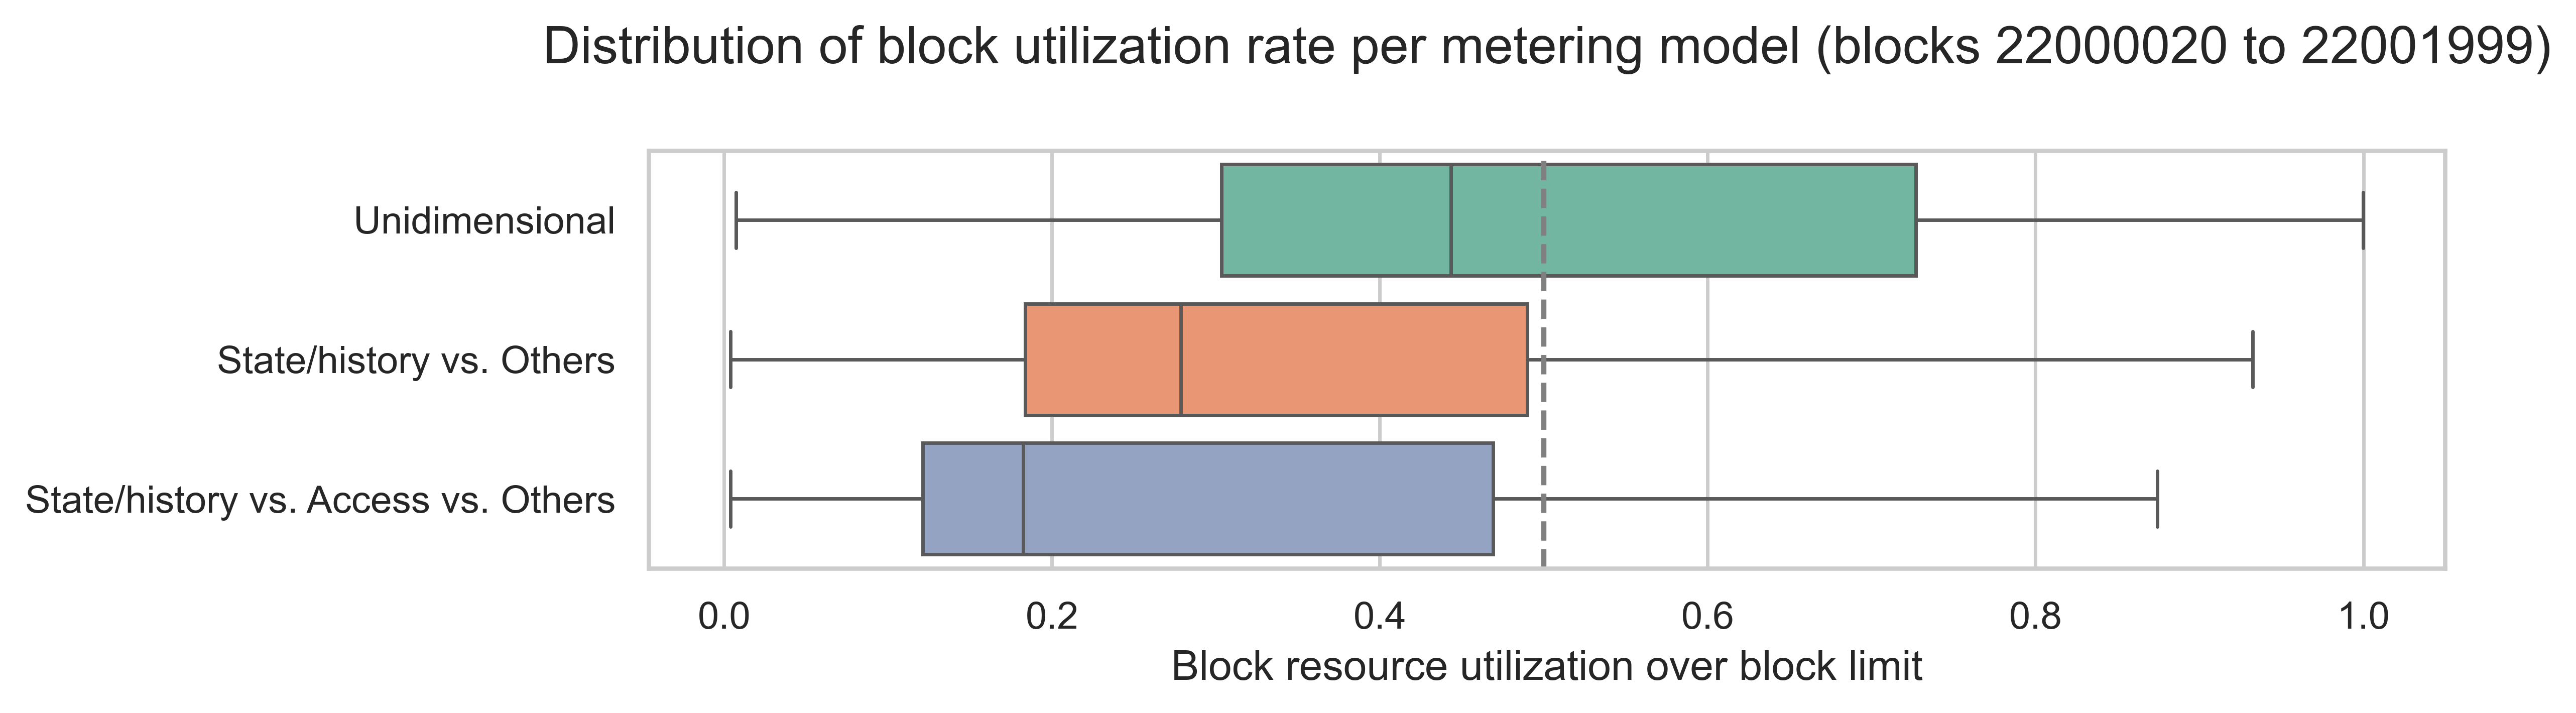

In [31]:
plt.figure(figsize=(10, 3))
sns.boxplot(data=util_melt_df, x="perc_over_limit", y="meter", hue="meter",legend=False,)
plt.axvline(x=0.5, color='grey', linestyle='--')
plt.xlabel("Block resource utilization over block limit")
plt.ylabel("")
plt.title("Distribution of block utilization rate per metering model (blocks 22000020 to 22001999)", pad=25)
plt.tight_layout()
plt.show()

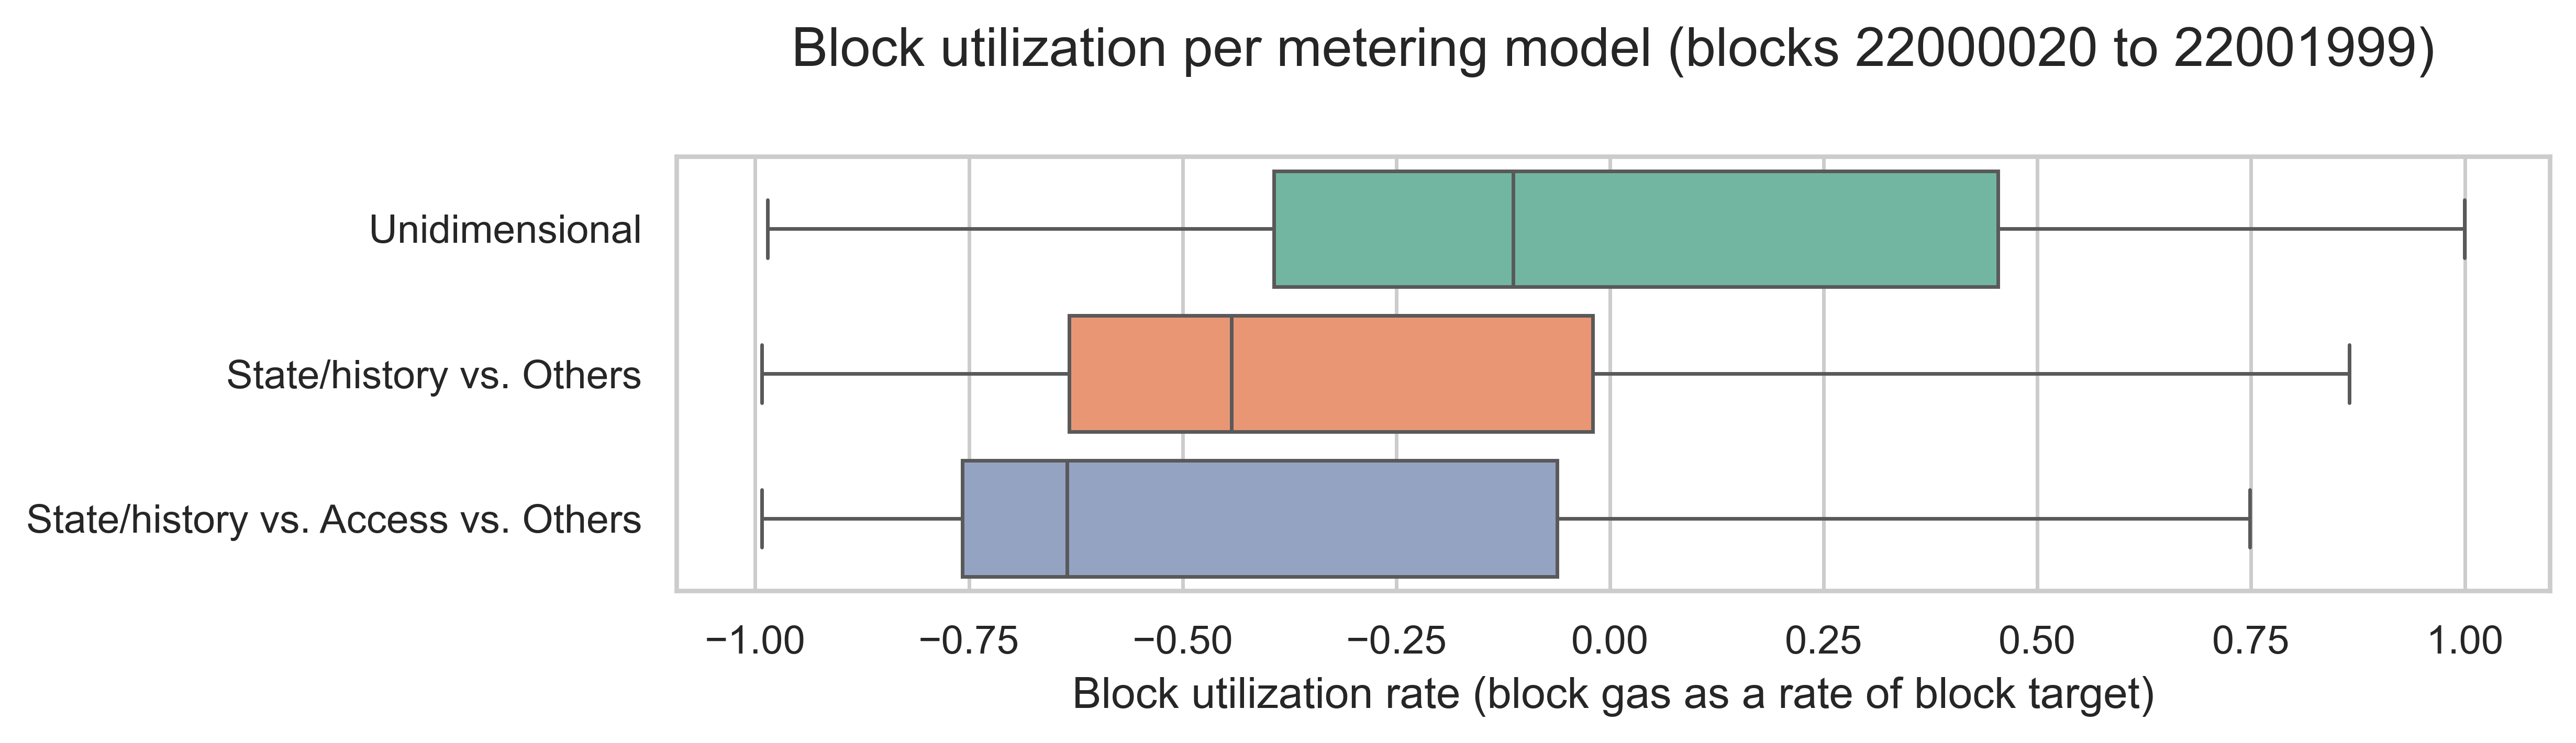

In [24]:
plt.figure(figsize=(10, 3))
sns.boxplot(data=util_melt_df, x="utilization", y="meter", hue="meter",legend=False,)
plt.xlabel("Block utilization rate (block gas as a rate of block target)")
plt.ylabel("")
plt.title("Block utilization per metering model (blocks 22000020 to 22001999)", pad=25)
plt.tight_layout()
plt.show()

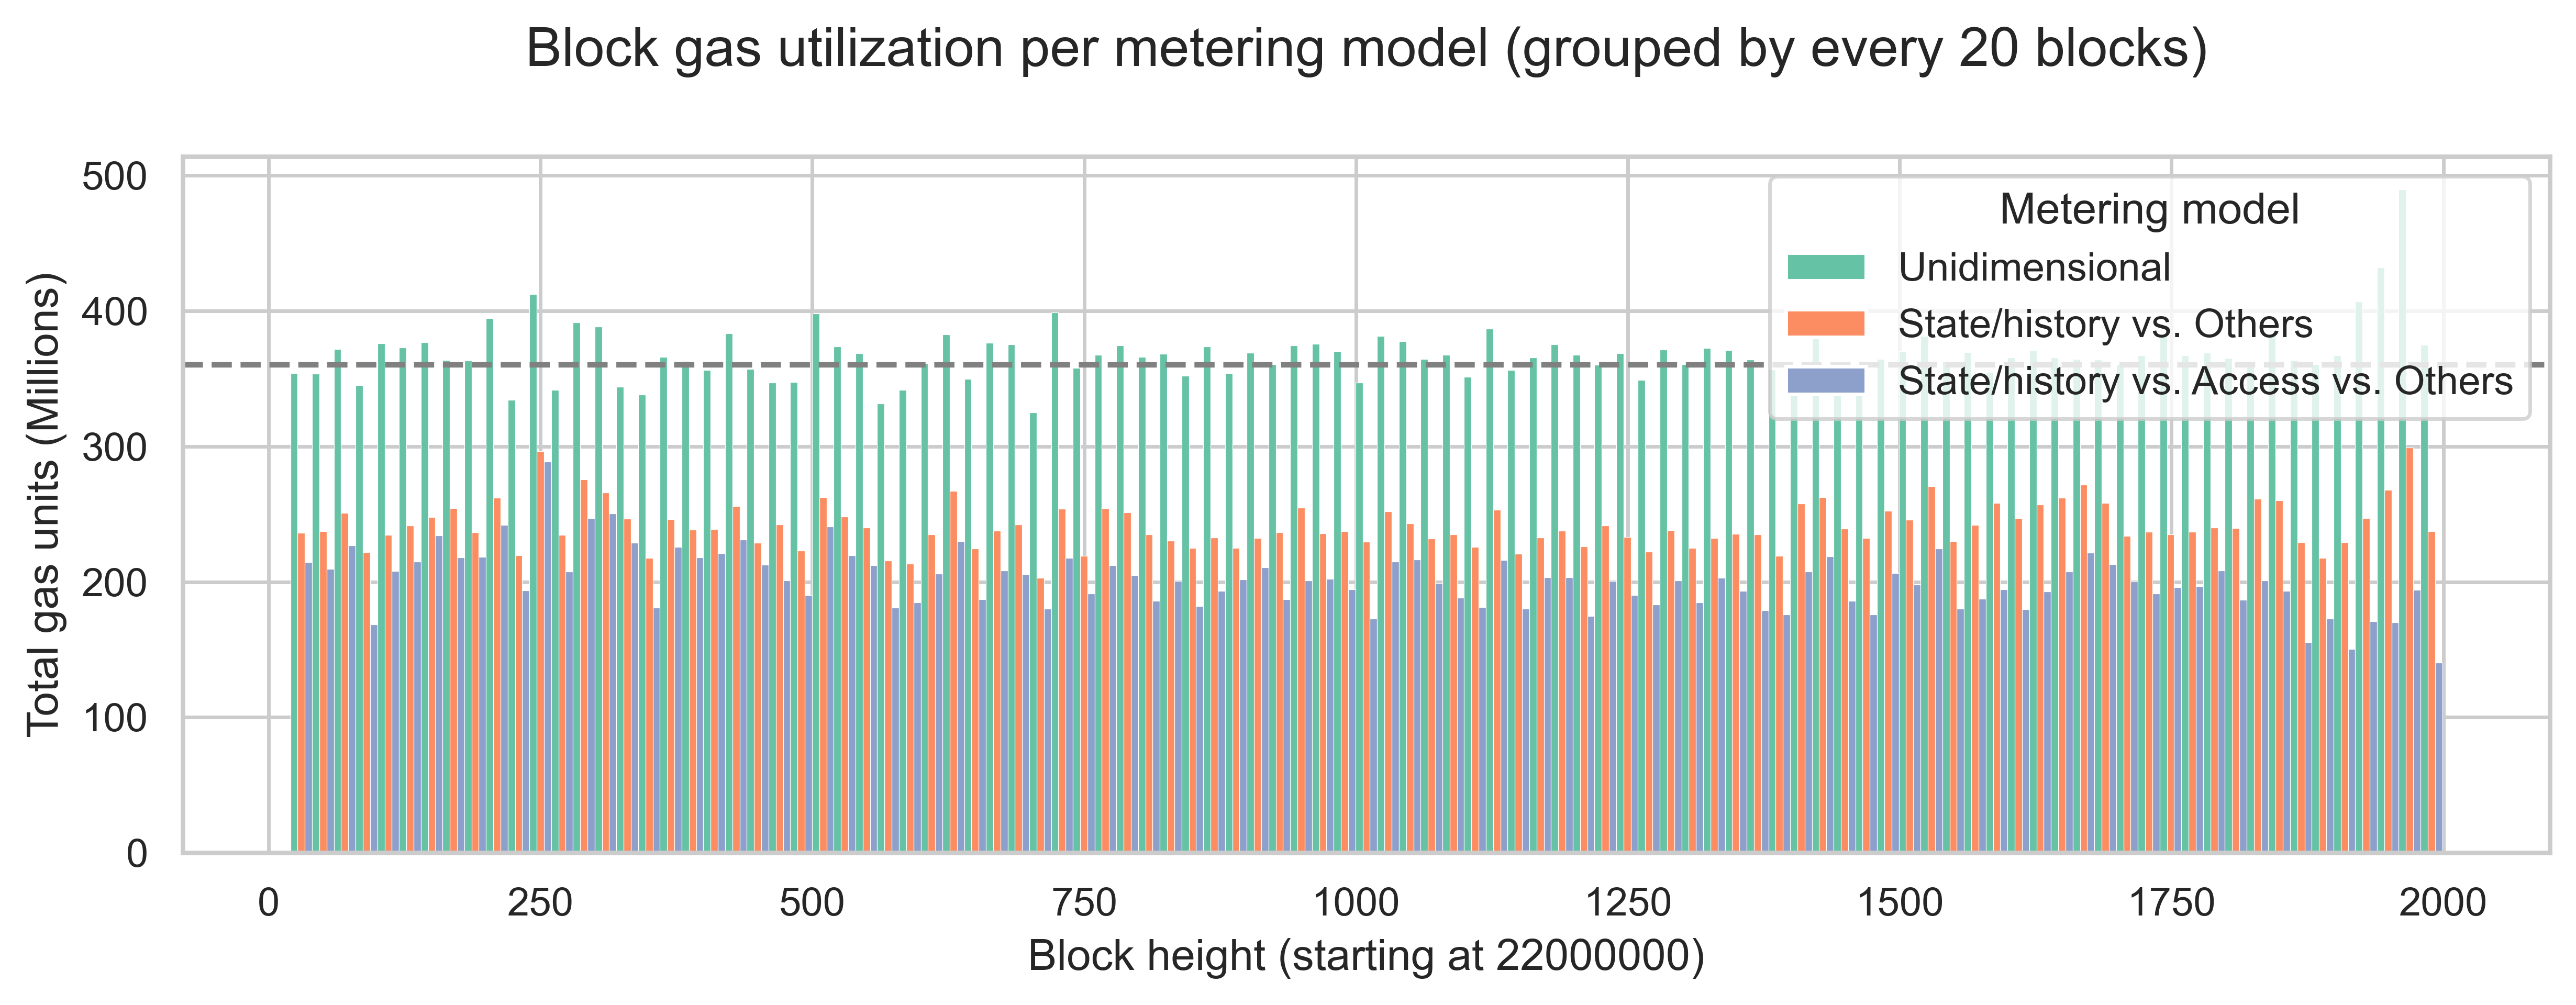

In [36]:
temp_df = util_melt_df.rename(columns={"meter": "Metering model"}).copy()
temp_df["usage"] = temp_df["usage"] / 1_000_000
temp_df["block_height"] = temp_df["block_height"] - 22000000

plt.figure(figsize=(10, 4))
ax = sns.histplot(
    temp_df,
    x="block_height",
    weights="usage",
    hue="Metering model",
    multiple="dodge",
    binwidth=20,
    alpha=1.0
)
plt.title(
    "Block gas utilization per metering model (grouped by every 20 blocks)",
    pad=25,
)
plt.xlabel("Block height (starting at 22000000)")
plt.ylabel("Total gas units (Millions)")
plt.axhline(y=180*2, color='grey', linestyle='--', label='target block size')

plt.tight_layout()
plt.show()